In [1]:
from datetime import datetime

import numpy as np

import dataset_utils as dataset
import torch as t

from ML_cup.pytorch import *

In [2]:
import os

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available")
    torch.set_default_device(torch.device("cuda"))
print(f"Using device: {torch.cuda.current_device()}")
print(f"Available cpu count: {os.cpu_count()}")

GPU is available
Using device: 0
Available cpu count: 16


In [3]:
dev_data = dataset.load_dataset("../data/ML-CUP24-TR.csv")
blind_data = dataset.load_dataset("../data/ML-CUP24-TS.csv")

In [4]:
import time

# get a seed for the random state based on the current time
rand = int(time.time())
print(f"Random seed: {rand}")
np.random.seed(rand)

Random seed: 1740911452


In [5]:
dev_data, scaler = dataset.rescale_dataset(dev_data)
blind_data, _ = dataset.rescale_dataset(blind_data, scaler)

In [6]:
# Split the dev data into train and validation with k-fold cross validation and minibatch
train_loaders, val_loaders, dev_loader, test_loader = dataset.torch_k_fold(dataset=dev_data, random_state=rand,
                                                                           batch_size=20, folds=5)
blind_loader = DataLoader(dataset.CupDataset(blind_data, device=torch.device('cuda')))
print(f"Dev loader: {len(dev_loader)}"
      f"\nTest loader: {len(test_loader)}"
      )
for i, (train, val) in enumerate(zip(train_loaders, val_loaders)):
    print(f"Fold {i + 1}: Train: {len(train)} Validation: {len(val)}")

Dev loader: 10
Test loader: 3
Fold 1: Train: 8 Validation: 2
Fold 2: Train: 8 Validation: 2
Fold 3: Train: 8 Validation: 2
Fold 4: Train: 8 Validation: 2
Fold 5: Train: 8 Validation: 2


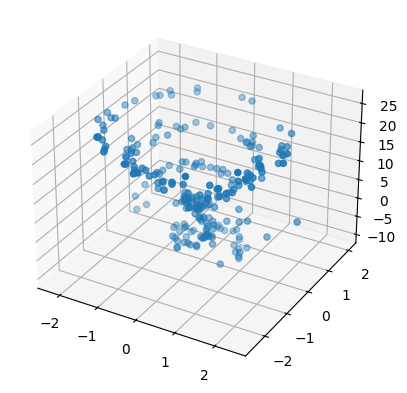

In [7]:
# plot the dev data's targets on xyz axis
# the targets are the last 3 columns of the data
y = np.array(dev_data)[:, -3:]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:, 0], y[:, 1], y[:, 2])
plt.show()

    ax.scatter(outputs[:, 0], outputs[:, 1], outputs[:, 2])
# Model Definitions

In [8]:
def MLP() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 200),
        t.nn.Tanh(),
        t.nn.Linear(200, 200),
        t.nn.Tanh(),
        t.nn.Linear(200, 3)
    )


def MLPr() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 200),
        t.nn.ReLU(),
        t.nn.Linear(200, 200),
        t.nn.ReLU(),
        t.nn.Linear(200, 3)
    )


def MLPbn() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 200),
        t.nn.Tanh(),
        t.nn.BatchNorm1d(200),
        t.nn.Linear(200, 200),
        t.nn.Tanh(),
        t.nn.BatchNorm1d(200),
        t.nn.Linear(200, 3)
    )


def MLPv2() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 300),
        t.nn.Tanh(),
        t.nn.Linear(300, 300),
        t.nn.Tanh(),
        t.nn.Linear(300, 3)
    )


def MLPv3() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 100),
        t.nn.Tanh(),
        t.nn.Linear(100, 200),
        t.nn.Tanh(),
        t.nn.Linear(200, 300),
        t.nn.Tanh(),
        t.nn.Linear(300, 3)
    )

# Grid search for the best parameters

# Model v1

## SGD

In [9]:
parameters = [
    {
        'optimizer': 'SGD',
        'lr': np.linspace(0.0075, 0.000075, 5),
        'weight_decay': np.linspace(0.01, 0.00001, 5),
        'momentum': [ 0.9, 0.95, 0.8],
        'nesterov': [True, False]
    }
]

In [10]:
# perform grid search to find the best parameters
best_pytorch_params, best_model = grid_search(model_builder=MLP, parameters=parameters, random_seed=rand,
                                              train_loader=train_loaders,
                                              val_loader=val_loaders, max_epochs=1500,
                                              scheduler=('', {}),
                                              stability_threshold=0.25, patience=10,
                                              clip=1.0,
                                              tensorboard_folder_base=f'runs/minibatch/MLP/SGD/rescaled/{rand}')

Avg Train MEE: 0.4848847448825836, Avg Val MEE: 1.030915766954422, Avg Fluctuation: 0.003205328004679294
('SGD', {'lr': 0.0075, 'weight_decay': 0.00889, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 0.5007902026176453, Avg Val MEE: 1.0601315379142762, Avg Fluctuation: 0.0029978708307901863
('SGD', {'lr': 0.0075, 'weight_decay': 0.0077800000000000005, 'momentum': 0.9, 'nesterov': False}, 1.0)
Avg Train MEE: 0.4991675645112991, Avg Val MEE: 1.0516196489334106, Avg Fluctuation: 0.0008180057663476393
('SGD', {'lr': 0.0075, 'weight_decay': 0.00889, 'momentum': 0.8, 'nesterov': True}, 1.0)
Avg Train MEE: 0.4661265850067139, Avg Val MEE: 1.0195392847061158, Avg Fluctuation: 0.0023733029310980132
('SGD', {'lr': 0.0075, 'weight_decay': 0.0077800000000000005, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 0.4855762541294098, Avg Val MEE: 1.0360525667667388, Avg Fluctuation: 0.002811527417081693
('SGD', {'lr': 0.0075, 'weight_decay': 0.00889, 'momentum': 0.9, 'nesterov': Fals

ValueError: Nesterov momentum requires a momentum and zero dampening

{'lr': 0.0025, 'weight_decay': 0.0025, 'momentum': 0.95, 'nesterov': False, 'optimizer': 'SGD'}
Evaluating the model on the test set
0.7992019653320312


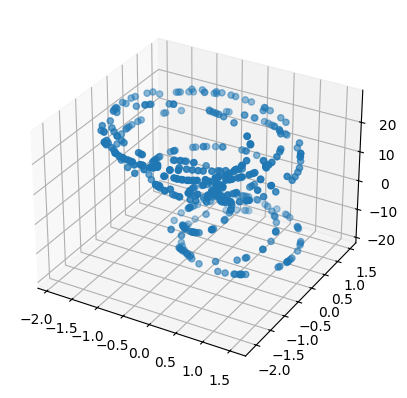

array([[  0.2730102 ,  -1.9128574 ,  23.966526  ],
       [ -0.6938356 ,   1.154108  ,  23.320564  ],
       [  1.3008258 ,   0.13690369, -15.984097  ],
       ...,
       [  0.73307014,  -1.8012726 ,  25.009304  ],
       [  0.23398435,   0.9307774 ,  -7.6433477 ],
       [  0.04786804,   0.17223264,  -2.4364772 ]], dtype=float32)

In [10]:
# retrain the model with the best parameters on the whole dataset
print(best_pytorch_params)
model_v1 = best_model
# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(model_v1, test_loader))

blind_test(model_v1, blind_loader, rand)

## Adam

In [11]:
parameters = [
    {
        'optimizer': 'Adam',
        'lr': np.linspace(0.0005, 0.0001, 10),
        'weight_decay': np.linspace(0.001, 0.00001, 10),
    }]

Avg Train MEE: 0.42541144490242006, Avg Val MEE: 0.9284662187099457, Avg Fluctuation: 0.0016388120153938354
('Adam', {'lr': 0.0005, 'weight_decay': 0.00078}, 1.0)
Avg Train MEE: 0.4010320156812668, Avg Val MEE: 0.9074903786182403, Avg Fluctuation: 0.001925764352235396
('Adam', {'lr': 0.0005, 'weight_decay': 0.00022999999999999995}, 1.0)
Avg Train MEE: 0.41190828680992125, Avg Val MEE: 0.924783730506897, Avg Fluctuation: 0.002219095323561017
('Adam', {'lr': 0.0005, 'weight_decay': 0.0008900000000000001}, 1.0)
Avg Train MEE: 0.41198399364948274, Avg Val MEE: 0.9092871069908142, Avg Fluctuation: 0.0016807782747159973
('Adam', {'lr': 0.0005, 'weight_decay': 0.00045}, 1.0)
Avg Train MEE: 0.39964597672224045, Avg Val MEE: 0.8964079082012176, Avg Fluctuation: 0.0019683562973737494
('Adam', {'lr': 0.0005, 'weight_decay': 0.001}, 1.0)
Avg Train MEE: 0.4144241988658905, Avg Val MEE: 0.9178423047065735, Avg Fluctuation: 0.0013217136913928544
('Adam', {'lr': 0.00045555555555555556, 'weight_decay':

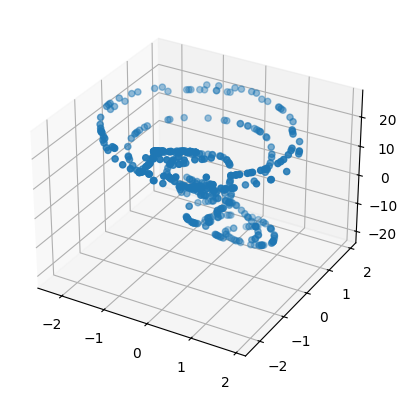

array([[ -0.4903704 ,  -1.3903805 ,  21.988451  ],
       [ -0.44399878,   1.7518977 ,  23.033808  ],
       [  1.0376217 ,   0.7482818 , -17.130861  ],
       ...,
       [ -0.36536127,  -1.2416732 ,  22.035656  ],
       [  0.17355107,   0.7145655 ,  -7.927314  ],
       [  0.3269745 ,   0.15170667,  -3.049584  ]], dtype=float32)

In [12]:
best_pytorch_params, best_model = grid_search(model_builder=MLP, parameters=parameters, random_seed=rand,
                                              train_loader=train_loaders, val_loader=val_loaders,
                                              scheduler=('', {}), max_epochs=1500,
                                              stability_threshold=0.25, patience=10,
                                              clip=1.0, tensorboard_folder_base=f'runs/minibatch/MLP/Adam/rescaled/{rand}')
# retrain the model with the best parameters on the whole dataset
print(best_pytorch_params)
model_v1 = best_model
# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(model_v1, test_loader))

blind_test(model_v1, blind_loader, rand)

In [ ]:
# with ReduceLRonPlateau
scheduler_params = {}
best_pytorch_params_scheduler, best_model_scheduler = grid_search(model_builder=MLP, parameters=parameters,
                                                                  random_seed=rand,
                                                                  train_loader=train_loaders, val_loader=val_loaders,
                                                                  scheduler=(
                                                                      'ReduceLRonPlateau',
                                                                      {'patience': 5, 'cooldown': 10, 'min_lr': 0.00001,
                                                                       'factor': 0.5},
                                                                  ),
                                                                  max_epochs=1500,
                                                                  stability_threshold=0.25, patience=10,
                                                                  clip=1.0,
                                                                  tensorboard_folder_base=f'runs/minibatch/MLP/Adam/plateau/{rand}')


Avg Train MEE: 0.38658069223165514, Avg Val MEE: 0.8702822834253311, Avg Fluctuation: 0.0025284889228878184
('Adam', {'lr': 0.0005, 'weight_decay': 0.0008900000000000001}, 1.0)
Avg Train MEE: 0.3798365965485573, Avg Val MEE: 0.8757484078407287, Avg Fluctuation: 0.001718502175188249
('Adam', {'lr': 0.00045555555555555556, 'weight_decay': 0.0008900000000000001}, 1.0)
Avg Train MEE: 0.37589327841997144, Avg Val MEE: 0.8635960638523101, Avg Fluctuation: 0.0023845234477713083
('Adam', {'lr': 0.00045555555555555556, 'weight_decay': 0.00078}, 1.0)
Avg Train MEE: 0.39061556160449984, Avg Val MEE: 0.8820647478103638, Avg Fluctuation: 0.002025690174272939
('Adam', {'lr': 0.0005, 'weight_decay': 0.00011999999999999999}, 1.0)
Avg Train MEE: 0.38681364208459856, Avg Val MEE: 0.8814759075641632, Avg Fluctuation: 0.0028933036788106638
('Adam', {'lr': 0.0005, 'weight_decay': 0.00045}, 1.0)
Avg Train MEE: 0.41392324268817904, Avg Val MEE: 0.8978622496128082, Avg Fluctuation: 0.002799397347950344
('Adam

In [ ]:
 # Model v1 with relu
parameters = [
    {
        'optimizer': 'Adam',
        'lr': np.linspace(0.00075, 0.00025, 10),
        'weight_decay': [0.0, 0.001, 0.0005]
    }]

best_pytorch_params, best_model = grid_search(model_builder=MLPr, parameters=parameters, random_seed=rand,
                                              train_loader=train_loaders, val_loader=val_loaders,
                                              scheduler=('', {}), max_epochs=1500,
                                              stability_threshold=0.25, patience=10,
                                              clip=1.0, tensorboard_folder_base=f'runs/minibatch/MLP/Adam/relu/{rand}')
print(best_pytorch_params, best_model)

# test the model on the test set
print("Evaluating the model on the test set")
print(torch_predict(best_model, test_loader))

blind_test(best_model, blind_loader, rand)

# Model v2

In [8]:
parameters = [
    {
        'optimizer': 'SGD',
        'lr': np.linspace(0.0025, 0.0001, 5),
        'weight_decay': [0.001, 0.005, 0.0015, 0.0025],
        'momentum': [0.9, 0.95],
        'nesterov': [True]
    },
    {
        'optimizer': 'Adam',
        'lr': np.linspace(0.0003, 0.000075, 10),
        'weight_decay': np.linspace(0.0001, 0.0005, 10),
    }
]

# perform grid search to find the best parameters
best_pytorch_params, best_model = grid_search(model_builder=MLPv2, parameters=parameters, train_loader=train_loaders,
                                              val_loader=val_loaders, scheduler=('', {}), max_epochs=1500,
                                              patience=20, clip=1.0, stability_threshold=0.2,
                                              tensorboard_folder_base=f'runs/minibatch//MLP2/{datetime.now().strftime("%Y-%m-%d_%H-%M")}_{rand}',
                                              random_seed=rand)

Avg Train MEE: 0.30347857177257537, Avg Val MEE: 0.7782932341098785, Avg Fluctuation: 0.0070881941027243905
('SGD', {'lr': 0.0025, 'weight_decay': 0.0025, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 0.33731748461723327, Avg Val MEE: 0.8240663230419158, Avg Fluctuation: 0.007182805966188846
('SGD', {'lr': 0.0025, 'weight_decay': 0.005, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 0.3277437582612038, Avg Val MEE: 0.8108435213565827, Avg Fluctuation: 0.008386181050885583
('SGD', {'lr': 0.0025, 'weight_decay': 0.001, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 0.3071654051542282, Avg Val MEE: 0.7941664338111878, Avg Fluctuation: 0.004459061041252245
('SGD', {'lr': 0.0019, 'weight_decay': 0.0015, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 0.3337695077061653, Avg Val MEE: 0.8203054904937744, Avg Fluctuation: 0.001836794541126114
('SGD', {'lr': 0.0025, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': True}, 1.0)
Avg Train MEE: 0.335795773

{'lr': 7.5e-05, 'weight_decay': 0.0005, 'optimizer': 'Adam'}
Evaluating the model on the test set
0.8227848410606384


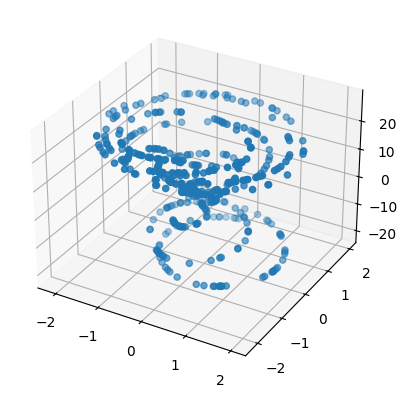

array([[ 4.9292594e-02, -2.0260601e+00,  2.4635921e+01],
       [-3.2039019e-01,  1.4867898e+00,  2.3110916e+01],
       [ 1.7159256e+00, -1.3678353e-01, -1.7142443e+01],
       ...,
       [ 8.2073522e-01, -1.7528789e+00,  2.5731647e+01],
       [-1.1600839e-02,  8.1777298e-01, -8.1911230e+00],
       [ 3.2290369e-02,  9.0436339e-02, -2.6503415e+00]], dtype=float32)

In [9]:
# retrain the model with the best parameters
#best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}
print(best_pytorch_params)

model_v2 = best_model

# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(model_v2, test_loader))

blind_test(model_v2, blind_loader, rand)

# Model v3

In [8]:
parameters_sgd3 = [
    {
        'optimizer': 'SGD',
        'lr': np.linspace(0.00075, 0.0001, 5),
        'weight_decay': [0.001, 0.0005, 0.0015, 0.0025],
        'momentum': [0.8, 0.9],
        'nesterov': [True]
    }]
parameters_adam3 = [
    {
        'optimizer': 'Adam',
        'lr': np.linspace(0.000025, 0.0000075, 5),
        'weight_decay': np.linspace(0.0001, 0.00005, 10)
    }]

In [9]:
# perform grid search to find the best parameters
best_pytorch_params, best_model = grid_search(model_builder=MLPv3, parameters=parameters_sgd3,
                                              train_loader=train_loaders,
                                              val_loader=val_loaders,
                                              scheduler=('', {}),
                                              clip=1.0, max_epochs=1500,
                                              stability_threshold=0.5, patience=20,
                                              tensorboard_folder_base=f'runs/minibatch/MLP3/SGD/tanh/{rand}',
                                              random_seed=rand)

Avg Train MEE: 0.48566984534263613, Avg Val MEE: 1.0293152034282684, Avg Fluctuation: 0.0007894207311450385
('SGD', {'lr': 0.00075, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': True}, 1.0)
Avg Train MEE: 0.5140119194984436, Avg Val MEE: 1.068078988790512, Avg Fluctuation: 0.0004631846708591654
('SGD', {'lr': 0.0005875, 'weight_decay': 0.0005, 'momentum': 0.9, 'nesterov': True}, 1.0)
Avg Train MEE: 0.5226434290409088, Avg Val MEE: 1.0860179603099822, Avg Fluctuation: 0.00024542692304045275
('SGD', {'lr': 0.0005875, 'weight_decay': 0.001, 'momentum': 0.8, 'nesterov': True}, 1.0)
Avg Train MEE: 0.53793406188488, Avg Val MEE: 1.0994611918926238, Avg Fluctuation: 0.00031729596120705686
('SGD', {'lr': 0.00075, 'weight_decay': 0.0025, 'momentum': 0.8, 'nesterov': True}, 1.0)
Avg Train MEE: 0.5008011132478714, Avg Val MEE: 1.051628428697586, Avg Fluctuation: 0.0007338682390979087
('SGD', {'lr': 0.00075, 'weight_decay': 0.0025, 'momentum': 0.9, 'nesterov': True}, 1.0)
Avg Train MEE: 0.54

{'lr': 0.0001, 'weight_decay': 0.0025, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}
Evaluating the model on the test set
0.8796340227127075


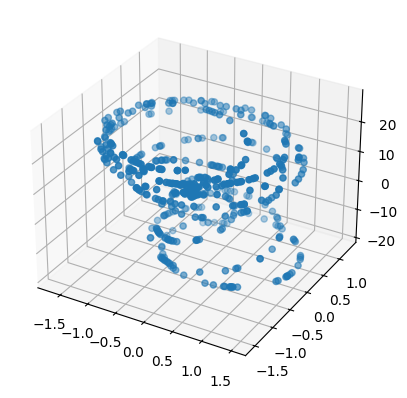

array([[  0.24807097,  -1.4253293 ,  22.183296  ],
       [ -0.242879  ,   0.6974097 ,  23.499138  ],
       [  1.5007068 ,  -0.10910481, -15.605172  ],
       ...,
       [  0.7512741 ,  -1.3191617 ,  23.92498   ],
       [  0.11129127,   0.92365474,  -7.7920823 ],
       [ -0.21165556,   0.38008884,  -2.9868183 ]], dtype=float32)

In [10]:
# retrain the model with the best parameters
# best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}
print(best_pytorch_params)

model_v3 = best_model

# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(model_v3, test_loader))

blind_test(model_v3, blind_loader, rand)

In [11]:
# perform grid search to find the best parameters
best_pytorch_params, best_model = grid_search(model_builder=MLPv3, parameters=parameters_adam3,
                                              train_loader=train_loaders,
                                              val_loader=val_loaders,
                                              scheduler=('', {}),
                                              clip=1.0, max_epochs=1500,
                                              stability_threshold=0.5, patience=20,
                                              tensorboard_folder_base=f'runs/minibatch/MLP3/Adam/tanh/{rand}',
                                              random_seed=rand)

Avg Train MEE: 0.46972308605909346, Avg Val MEE: 0.9804831385612488, Avg Fluctuation: 0.0001655425197032398
('Adam', {'lr': 2.5e-05, 'weight_decay': 9.444444444444444e-05}, 1.0)
Avg Train MEE: 0.40042751282453537, Avg Val MEE: 0.900075888633728, Avg Fluctuation: 0.00020432726503340714
('Adam', {'lr': 2.5e-05, 'weight_decay': 5e-05}, 1.0)
Avg Train MEE: 0.373851016163826, Avg Val MEE: 0.8652251362800598, Avg Fluctuation: 0.00025637589032737897
('Adam', {'lr': 2.5e-05, 'weight_decay': 0.0001}, 1.0)
Avg Train MEE: 0.46005457937717437, Avg Val MEE: 0.9655601501464843, Avg Fluctuation: 0.00013172810490598842
('Adam', {'lr': 2.0625e-05, 'weight_decay': 9.444444444444444e-05}, 1.0)
Avg Train MEE: 0.46163505911827085, Avg Val MEE: 0.9771158814430236, Avg Fluctuation: 0.00011393858553196871
('Adam', {'lr': 2.0625e-05, 'weight_decay': 7.777777777777778e-05}, 1.0)
Avg Train MEE: 0.5045650839805603, Avg Val MEE: 1.0134276688098907, Avg Fluctuation: 0.00011388949954140074
('Adam', {'lr': 2.0625e-05

{'lr': 7.5e-06, 'weight_decay': 5e-05, 'optimizer': 'Adam'}
Evaluating the model on the test set
0.8271116614341736


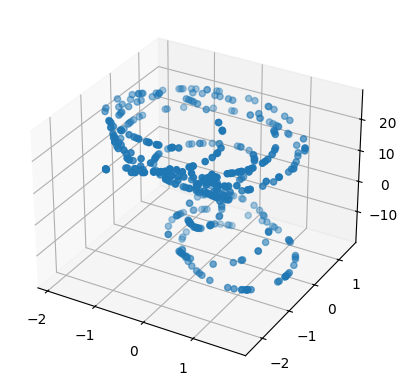

array([[ -0.28862074,  -2.323492  ,  22.96025   ],
       [ -0.5288211 ,   0.8864871 ,  22.887384  ],
       [  1.698394  ,  -0.4217968 , -14.9752655 ],
       ...,
       [  0.33673993,  -2.0047736 ,  24.197012  ],
       [  0.06586047,   0.85574347,  -7.96537   ],
       [ -0.20993666,   0.17597397,  -2.8035371 ]], dtype=float32)

In [12]:
# retrain the model with the best parameters
# best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}
print(best_pytorch_params)

model_v3 = best_model

# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(model_v3, test_loader))

blind_test(model_v3, blind_loader, rand)

# CUP TEST

In [18]:
def torch_pred(model, test_loader: DataLoader):
    # evaluate the model on the test set using mee metric
    predictions = []
    true = []
    with torch.no_grad():
        for data, true in test_loader:
            output = model(data)
            predictions.append(output)
    return predictions, true


In [19]:
from ML_cup.dataset_utils import CupDataset

test_loader = DataLoader(CupDataset(blind_data, device=torch.device('cuda')))



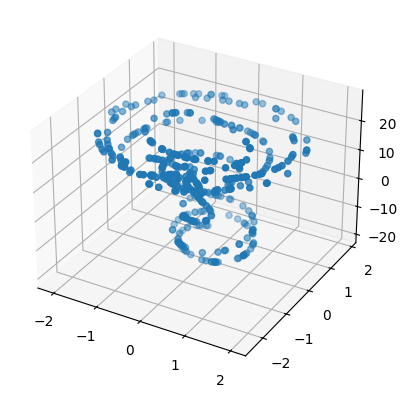

array([[ -0.0561322 ,  -2.397471  ,  23.873005  ],
       [ -0.34724066,   1.2807254 ,  22.465273  ],
       [  0.8989795 ,  -0.03142555, -16.643982  ],
       ...,
       [  0.7548931 ,  -2.0502098 ,  25.45574   ],
       [  0.04791361,   0.8626606 ,  -7.562338  ],
       [ -0.23828107,   0.08956189,  -2.861122  ]], dtype=float32)

In [20]:
predictions = blind_test(model_v1, test_loader, rand)
predictions

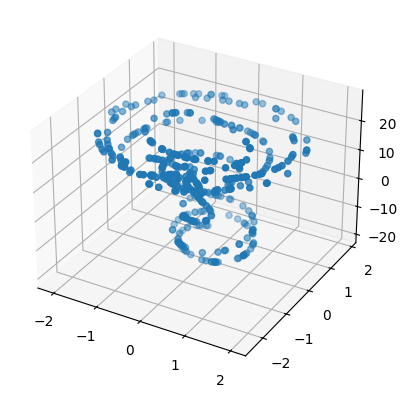

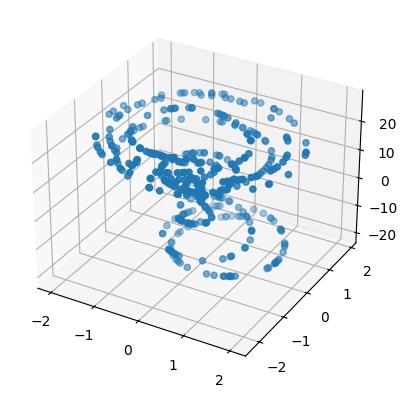

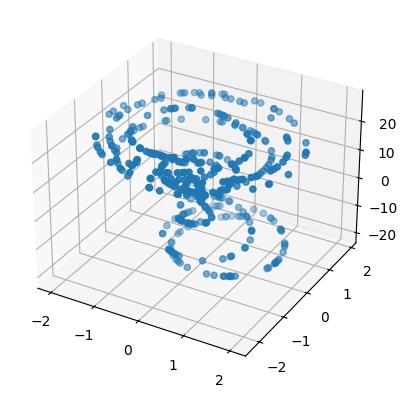

In [21]:
predictions = blind_test(model_v1, test_loader, rand)
predictions = blind_test(model_v2, test_loader, rand)
predictions = blind_test(model_v3, test_loader, rand)

In [22]:
# save the predictions to a file
np.savetxt('../ML_cup/predictions.csv', predictions, delimiter=',', fmt='%f')

In [ ]:
# batchnorm blind test
blind_test(model_v1, blind_loader, rand)